# Feature Engineering on QPESUMS dataset

In the notebook [`PCA Tutorial`](https://github.com/tingsyo/qpetw/blob/master/examples/tutorial_PCA.ipynb), we demonstrated how to perform PCA on the QPESUMS data as well as some subsetting and preliminary analysis. Since our purpose is using QPESUMS data to predict the precipitation, it is useful to do some feature engineering before we jump into actual machine learning models.

The sizes of the sub-datasets that used for PCA:

|dataset|number of records|
|-------|-----------------|
|Full|34369|
|1mm/hr|11260|
|5mm/hr|4456|
|10mm/hr|2150|
|20mm/hr|858|
|40mm/hr|236|
|Typhoon warning|1517|


First, let's recall some results of our PCA.

- The 1st PC of each sub-set of QPESUMS are similar in general, with small shifts in the major variation.
- We investigated in the relationship between the precipitation and the projections of the top 10 PCs (data in the reduced space), it seems except the 1st PC, all later PCs are quadratically in proportional to the precipitation.

Following is a illustration on the full dataset:

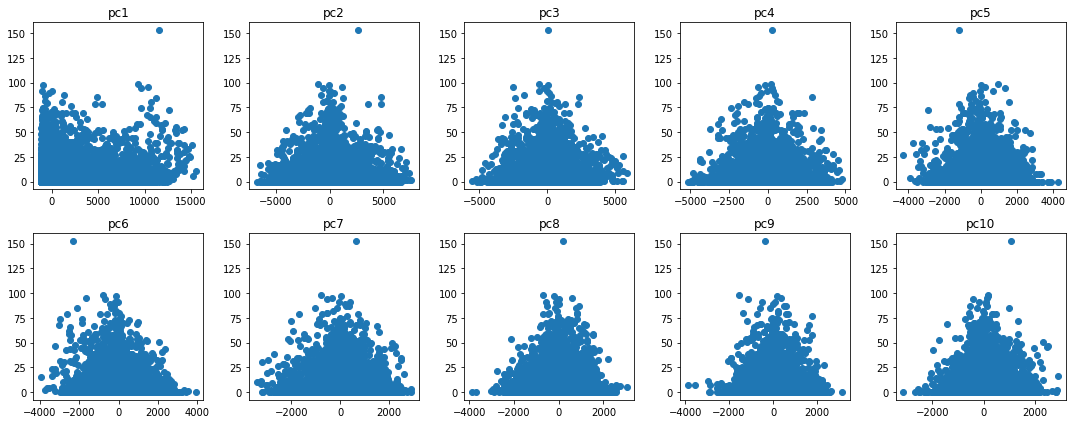

0

In [1]:
import numpy as np
import pandas as pd
# Read precipitation data
tmp = pd.read_csv('./data/t1hr.csv')
# Calculate maximal precipitation among 45 stations
dates = tmp['date']
t1hr = tmp.iloc[:,1:]
t1hr_max = pd.DataFrame({'timestamp':dates, 'prec':t1hr.max(axis=1)})

%matplotlib inline
import matplotlib.pyplot as plt

def show_prec_on_pc(prec, pcfile, nl=10):
    # Read projections on PCs
    pcs = pd.read_csv(pcfile)
    # Merge two dataframes
    tmp = pd.merge(prec, pcs, on='timestamp')
    # Making plots
    for i in range(nl):
        ax = plt.subplot(2, nl/2, i+1)
        ax.scatter(tmp.iloc[:,i+2],tmp['prec'])
        ax.set_title(tmp.columns[i+2])
    plt.tight_layout()
    plt.show()
    return(0)

plt.figure(figsize=(15,6))
show_prec_on_pc(t1hr_max, '../ws.flt/proj_full.csv')

The figure above shows that for PC2 ~ PC10, the projections seem to be quadratically in proportional to the precipitation. So, let's see if it's the case.

In [2]:
import numpy as np
import pandas as pd

prec = t1hr_max
# Read projections on PCs
pcs = pd.read_csv('../ws.flt/proj_full.csv')
# Merge two dataframes
tmp = pd.merge(prec, pcs, on='timestamp')

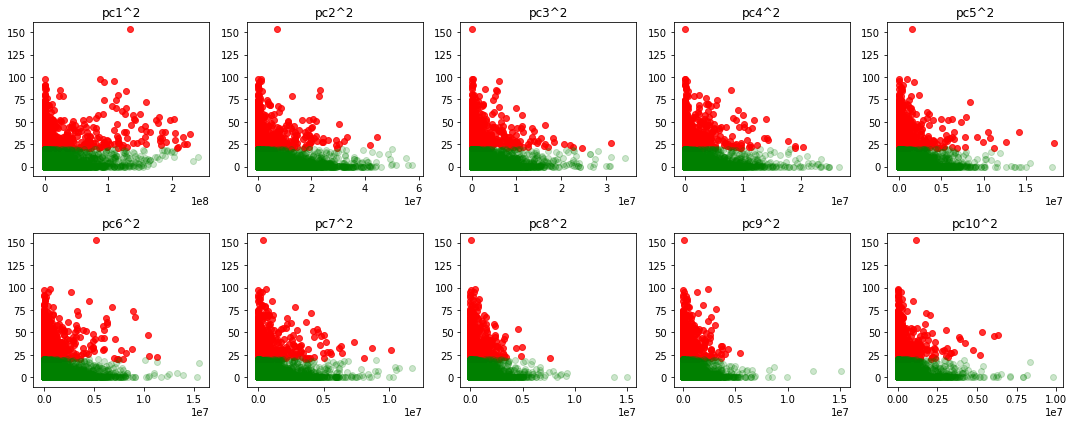

In [3]:
# Making plots
plt.figure(figsize=(15,6))
tmp['hr'] = (tmp['prec']>20.)
dhr1 = tmp.loc[tmp['hr'],:]
dhr0 = tmp.loc[~tmp['hr'],:]
for i in range(10):
    ax = plt.subplot(2, 10/2, i+1)
    ax.scatter(dhr1.iloc[:,i+2]*dhr1.iloc[:,i+2],dhr1['prec'], c='r', alpha=0.8)
    ax.scatter(dhr0.iloc[:,i+2]*dhr0.iloc[:,i+2],dhr0['prec'], c='g', alpha=0.2)
    ax.set_title(tmp.columns[i+2]+'^2')
plt.tight_layout()
plt.show()

C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


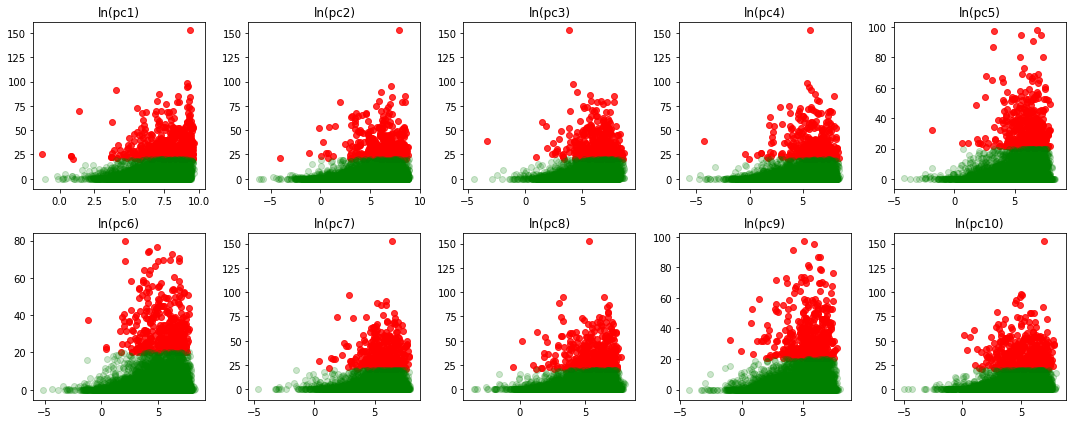

In [8]:
# Making plots
plt.figure(figsize=(15,6))
tmp['hr'] = (tmp['prec']>20.)
for i in range(10):
    ax = plt.subplot(2, 10/2, i+1)
    ax.scatter(np.log(dhr1.iloc[:,i+2]),dhr1['prec'], c='r', alpha=0.8)
    ax.scatter(np.log(dhr0.iloc[:,i+2]),dhr0['prec'], c='g', alpha=0.2)
    ax.set_title('ln('+tmp.columns[i+2]+')')
plt.tight_layout()
plt.show()

We tried to use logarithm and square of the projections, and it appears logarithm is better. Also, logarithm is more reasonable since the measurement of reflectivity should behave logarithmically in nature.

However, the PCA projections seem to provide only **'necessary condition'** instead of 'sufficient condiftion' to large precipitation. We need to further investigate what features can provide more sufficient information for heavy rainfall.


## Feature Selection Technique

The classes in the [`sklearn.feature_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.

Let's first build a linear model with 10 PCs from each subset and the logarithm of these PCs.

### Input Data Processing

In [5]:
# Read projections
pfull = pd.read_csv('../ws.flt/proj_full.csv')
pfp40 = pd.read_csv('../ws.flt/proj_fp40.csv')
pftyw = pd.read_csv('../ws.flt/proj_tyw.csv')

# Create new column names
pfull.columns = ['full_'+i for i in pfull.columns]
pfp40.columns = ['fp40_'+i for i in pfp40.columns]
pftyw.columns = ['ftyw_'+i for i in pftyw.columns]
pfull.rename(columns={'full_timestamp':'timestamp'}, inplace=True)
pfp40.rename(columns={'fp40_timestamp':'timestamp'}, inplace=True)
pftyw.rename(columns={'ftyw_timestamp':'timestamp'}, inplace=True)
#print(list(pfull.columns))
#print(list(pfp40.columns))
#print(list(pftyw.columns))

# Clean up
data = pd.merge(pd.merge(pfull.iloc[:,:11], pfp40.iloc[:,:11], on='timestamp'),pftyw.iloc[:,:11], on='timestamp')
data.index = list(data['timestamp'])
data = data.iloc[:,1:]

# Add logarithm
for i in range(data.shape[1]):
    data['ln_'+list(data.columns)[i]] = np.log(data.iloc[:,i])

# Check
print("Input data shape:")
print(data.shape)
print(list(data.columns))

Input data shape:
(34369, 60)
['full_pc1', 'full_pc2', 'full_pc3', 'full_pc4', 'full_pc5', 'full_pc6', 'full_pc7', 'full_pc8', 'full_pc9', 'full_pc10', 'fp40_pc1', 'fp40_pc2', 'fp40_pc3', 'fp40_pc4', 'fp40_pc5', 'fp40_pc6', 'fp40_pc7', 'fp40_pc8', 'fp40_pc9', 'fp40_pc10', 'ftyw_pc1', 'ftyw_pc2', 'ftyw_pc3', 'ftyw_pc4', 'ftyw_pc5', 'ftyw_pc6', 'ftyw_pc7', 'ftyw_pc8', 'ftyw_pc9', 'ftyw_pc10', 'ln_full_pc1', 'ln_full_pc2', 'ln_full_pc3', 'ln_full_pc4', 'ln_full_pc5', 'ln_full_pc6', 'ln_full_pc7', 'ln_full_pc8', 'ln_full_pc9', 'ln_full_pc10', 'ln_fp40_pc1', 'ln_fp40_pc2', 'ln_fp40_pc3', 'ln_fp40_pc4', 'ln_fp40_pc5', 'ln_fp40_pc6', 'ln_fp40_pc7', 'ln_fp40_pc8', 'ln_fp40_pc9', 'ln_fp40_pc10', 'ln_ftyw_pc1', 'ln_ftyw_pc2', 'ln_ftyw_pc3', 'ln_ftyw_pc4', 'ln_ftyw_pc5', 'ln_ftyw_pc6', 'ln_ftyw_pc7', 'ln_ftyw_pc8', 'ln_ftyw_pc9', 'ln_ftyw_pc10']


C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log


### Output data processing

For testing, we simply use the maximal rainfall onver the 45 stations.

In [9]:
tmp = pd.merge(data, t1hr_max, left_index=True, right_on='timestamp')
y = tmp['prec']

idx2015 = sum(tmp['timestamp']<=2015010101)
print('Data index before 2015')
print(idx2015)
idx2016 = sum(tmp['timestamp']<=2016010101)
print('Data index before 2016')
print(idx2016)

print("Output data shape:")
print(y.shape)

Data index before 2015
17382
Data index before 2016
26059
Output data shape:
(34369,)


### Split the training and testing data

We can simply use 2013 ~ 2015 for training and 2016 for testing. However, since we already know that 2016 is a strange year, let's use 2013/2014 for training and 2015 for testing.

In [18]:
# Split data
x_train = data.iloc[:idx2015,:]
x_test = data.iloc[idx2015:idx2016,:]
y_train = y.iloc[:idx2015,]
y_test = y.iloc[idx2015:idx2016,]

print("Training data dimension:")
print(x_train.shape)
print(y_train.shape)
print("Test data dimension:")
print(x_test.shape)
print(y_test.shape)

Training data dimension:
(17382, 60)
(17382,)
Test data dimension:
(8677, 60)
(8677,)


### Generalized Linear Model

Let's see if we just put everything into a GLM 

In [20]:
import statsmodels.api as sm

# Fit the classifier
glm = sm.GLM(y_train.reset_index(drop=True), x_train.fillna(0.).reset_index(drop=True), missing='drop')
glm_results = glm.fit()

print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   prec   No. Observations:                17382
Model:                            GLM   Df Residuals:                    17322
Model Family:                Gaussian   Df Model:                           59
Link Function:               identity   Scale:                          32.522
Method:                          IRLS   Log-Likelihood:                -54895.
Date:                Thu, 12 Sep 2019   Deviance:                   5.6334e+05
Time:                        11:26:50   Pearson chi2:                 5.63e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
full_pc1        -0.0114      0.001     -9.261   

In [ ]:
# Utility to plot a 6*275*162 numpy array
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from mpl_toolkits.basemap import Basemap

lat0 = 21.8875
lat1 = 25.3125
lon0 = 120.0
lon1 = 122.0125

lats = np.arange(21.8875, 25.3125, 0.0125)
lons = np.arange(120.0, 122.0125, 0.0125)

def plot_dbz_6maps(data):
    import matplotlib.pyplot as plt
    # Get data dimensions
    nl, ny, nx = data.shape
    print('Data dimensions: ' + str(nl) + ' layers of ' + str(ny) + ' x ' + str(nx))
    # Making plot
    for i in range(nl):
        ax = plt.subplot(2, nl/2, i+1)
        # create basemap
        m = Basemap(llcrnrlon=lon0, urcrnrlon=lon1, llcrnrlat=lat0, urcrnrlat=lat1, resolution='l')
        # draw coastlines on map.
        m.drawcoastlines()
        m.imshow(data[i], alpha=0.99, cmap='Greys')#, vmin=0., vmax=60.)
        m.colorbar()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()
    return(0)

### Full Dataset (34369 records)

In [ ]:
pc5 = np.load('data/full_pc5.npy', allow_pickle=True)
d=pc5[0,:].reshape(6, 275, 162)
plot_dbz_6maps(d)

### Data with Precipitation >= 1mm (11260 records)

### Data with Precipitation >= 5mm (4456 records)

### Data with Precipitation >= 10mm (2150 records)

### Data with Precipitation >= 20mm (858 records)

### Data with Precipitation >= 40mm (236 records)

### Data with Typhoon Warnings (by CWB, 1517 records)

By illustrating the 1st PC of each slice of dataset, we can see:

1. In the full dataset, the PC1 showed the highest variation occurs at the west side of the middle ridge (中央山脈), as well as intermediate variation along all plain area (north, west, and south) except the south-east part of Taiwan.

2. By applying filters with different precipitation threshold, the major variation in the PC1 moved south-ward and east-ward, comparing to the full dataset.

3. The PC1 of the *heavy rainfall* (officially defined by CWB as 40mm/hr) cases showed not only a high variation on the southern of of the middle ridge but only on the southwest coast, which is not shown in other cases.

4. The PC1 of the typhoon cases is similar to the 10mm/hr and 20mm/hr dataset, except some intermediate variation on sea surface.

Next, we will see how the precipitation is related to these PCs of different dataset.



## Precipitations in  the PC-Space

We want to see how well the PCs from different dataset can inform us about the strength of precipitation. First we need to create a dataset contains time-stamp, precipitation, and projection on PCs.

### Data Processing

### Precipitation with PCs from the full dataset

### Precipitation with PCs from the dataset-40mmhr

### Precipitation with PCs from the dataset-typhoon

### Some observations

From the figures above, we found:

- None of the first 10 PCs is linearly correlated to the precipitation.

- Except PC1, heavy rain occurs when most PCs have projections close to 0.

- Different dataset have similar results, though highly filtered PC-k (k>1) have steeper slope.

These results may imply:

- We may only need a few PCs regradless the explained variance.

- Linear models might not work well.

- Try PCs from different dataset together.